<a href="https://colab.research.google.com/github/vicperotti/BANA780/blob/main/Wine_Reviews_from_Kaggle_NJOBS_and_RandSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this example, Let's look at preprocessing in sklearn
specifically I want to highlight....
encoding categorical variables
and imputing missing values


In [2]:
# This example from https://www.kaggle.com/zynicide/wine-reviews
# 2. Import libraries and modules
import numpy as np
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer, make_column_transformer


In [3]:
 data = pd.read_csv('winemag-data-130k-v2.csv') 
#data = pd.read_csv('winemag-data_first150k.csv')
#afinn = Afinn(emoticons=True)
len(data)

129971

In [4]:
#drop a bunch of rows to make this more quick to compute
np.random.seed(10)
remove_n = 50000
drop_indices = np.random.choice(data.index, remove_n, replace=False)
data = data.drop(drop_indices)
data.shape

(79971, 14)

In [5]:
# look a number of columns have missing values!
print(data.isnull().sum())

Unnamed: 0                   0
country                     33
description                  0
designation              23041
points                       0
price                     5549
province                    33
region_1                 12984
region_2                 48979
taster_name              16187
taster_twitter_handle    19249
title                        0
variety                      0
winery                       0
dtype: int64


In [6]:
#Oh why not add sentiment to description
#Note this takes a long time!
#data[['sentiment']] = data['description'].apply(lambda Text: pd.Series(afinn.score(Text)))

# DROP rows with missing values in each of the following
data2 = data.dropna(subset=['points','country','price', 'province','variety','winery'])
features = data2[['country','price', 'province','variety','winery']]
print("after dropping na there are %d rows left" % len(data2))
print(features.head())

after dropping na there are 74391 rows left
  country  price           province         variety           winery
2      US   14.0             Oregon      Pinot Gris        Rainstorm
3      US   13.0           Michigan        Riesling       St. Julian
4      US   65.0             Oregon      Pinot Noir     Sweet Cheeks
6   Italy   16.0  Sicily & Sardinia        Frappato  Terre di Giurfo
7  France   24.0             Alsace  Gewürztraminer         Trimbach


In the original example, the X variables were created by taking all the data and dropping the points (dependent variable) column. Because we instead chose specific columns aka features above, we don't need to do this.

In [ ]:
y = data2.points # data2['points']
#X = data.drop('points', axis=1)
X_train, X_test, y_train, y_test = train_test_split(features, y,
                                                    test_size=0.33,
                                                    random_state=42)

In [7]:
#how many cores can we use?
import multiprocessing
cores = multiprocessing.cpu_count()
cores

2

In [8]:
# so how do we handle those pesky categorical variables
#VIA https://scikit-learn.org/stable/modules/preprocessing.html
#AND https://jorisvandenbossche.github.io/blog/2018/05/28/scikit-learn-columntransformer/

preprocess = make_column_transformer(
    (preprocessing.OneHotEncoder(handle_unknown='ignore'),['country', 'province','variety','winery'] ),
    (preprocessing.StandardScaler(),['price'])
)

# 5. Declare data preprocessing steps
pipeline = make_pipeline(preprocess,
                         RandomForestRegressor(n_estimators=50,n_jobs=cores))

# 6. Declare hyperparameters to tune
hyperparameters = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestregressor__max_depth': [None, 5, 3, 1]}


In [ ]:
#https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85

In [12]:
from sklearn.model_selection import RandomizedSearchCV

rand_search = RandomizedSearchCV(pipeline, hyperparameters, random_state=0,cv=5,n_jobs=cores)
y = data2.points
%timeit rand_search.fit(features, y)

1 loop, best of 5: 54min 57s per loop


In [13]:
# 9. Evaluate model pipeline on test data
pred4 = rand_search.predict(features)
print (r2_score(y, pred4))
print (mean_squared_error(y, pred4))

0.875264133481134
1.155028725456543


In [14]:
# 10. Save model for future use
joblib.dump(rand_search, 'randwineregressordropnas.pkl')

['randwineregressordropnas.pkl']

In [15]:
rand_search.best_params_

{'randomforestregressor__max_depth': None,
 'randomforestregressor__max_features': 'sqrt'}

In [17]:
rand_search.best_estimator_

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='ignore',
                                                                sparse=True),
                                                  ['country', 'province',
                                                   'variety', 'winery']),
                                                 ('standardscaler',
                                                  Sta

In [21]:
feature_names = rand_search.best_estimator_.named_steps['columntransformer'].transformers_[0][1].get_feature_names()
feature_names = np.append(feature_names,['price'])

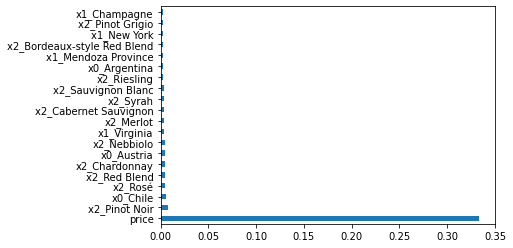

In [22]:
featimparray = rand_search.best_estimator_.named_steps['randomforestregressor'].feature_importances_

feat_importances = pd.Series(featimparray, index=feature_names)
feat_importances.nlargest(20).plot(kind='barh')